# [GD-2] Going Deeper(CV): ResNet Ablation Study

## 목차

>   <p style="font-size:17px">Step 1. Data 준비하기</p>
    <p style="font-size:17px">Step 2. Encoder 만들기</p> 
    <p style="font-size:17px">Step 3. Decoder 만들기</p>
    <p style="font-size:17px">Step 4. U-NetGenerator 만들기</p>
    <p style="font-size:17px">Step 5. Discriminator 만들기</p>
    <p style="font-size:17px">Step 6. 학습 및 테스트하기</p>


## 루브릭 (프로젝트 평가 기준)

> |<p style="font-size:15px"> 평가문항 </p>                                |<p style="font-size:15px"> 상세기준 </p>        |
  |------------------------------------------------------------------------|------------------------------------------------|
  |1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? | 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
  |2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? | cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
  |3. Ablation Study 결과가 바른 포맷으로 제출되었는가? | ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 텐서플로우에서 제공하는 `tensorflow-datasets` 패키지 설치 및 준비

In [2]:
!pip install tensorflow-datasets

# **1) CIFAR-10**
-----



In [4]:
import tensorflow as tf
import numpy as np
import os

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


Tensorflow 2.6.0 버전과 numpy 1.21.4 버전 설치가 필요함으로 uninstall을 진행한 후, 버전을 지정하여 설치를 시행합니다. 

In [5]:
# !pip uninstall tensorflow

In [6]:
# !pip install tensorflow==2.6.0

In [7]:
# !pip uninstall numpy

In [8]:
# !pip install numpy==1.21.4

In [9]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds 

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [10]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다. 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()    # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files = True, 
    with_info = True,
    
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteTZ3ZZB/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteTZ3ZZB/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [12]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print (ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [13]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


0 ~ 255 사이의 값으로 이루어진 이미지 데이터 정규화 진행을 위하여서 **Data Normalization** 을 진행합니다 

In [14]:
def normalize_and_resize_img(image, label):
  """Normlizes image: `uint8` -> `float32`."""
  # image = tf.image.resize(image, [32, 32])
  return tf.cast(image, tf.float32) / 255., label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

CIFAR-10 데이터셋은 이름에서 알 수 있듯이 10개 클래스를 가집니다.

In [16]:
ds_info.features["label"].num_classes

10

In [17]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

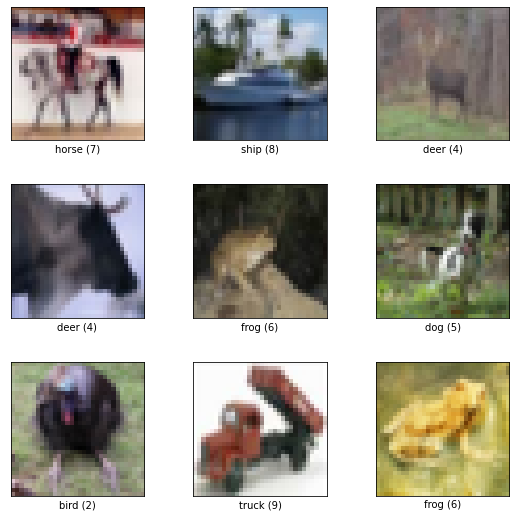

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

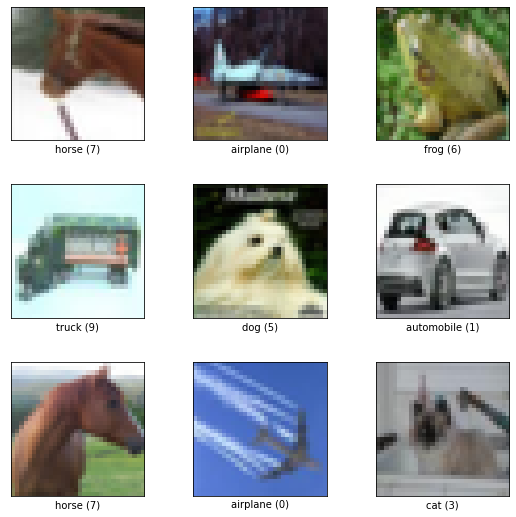

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

## **2) ResNet 기본 블록 구성하기**


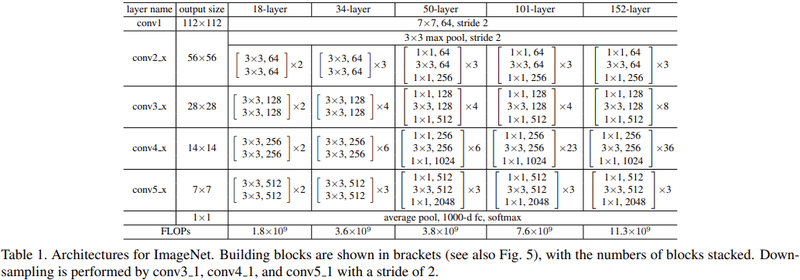

`ResNet-34`과 `ResNet-50`의 기본 구조가 되는 블록을 만든다고 가정하고 블록을 구현해봅니다.

- 두가지 구조 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태를 갖고 있습니다. 


In [20]:
# function for building ResNet Block

def conv_block (input_layer,
                channel = 64,
                kernel_size = 3, 
                strides = 1,
                activation='relu',
                ):
    
    # build convolution block
    x = keras.layers.Conv2D(filters = channel,
                            kernel_size = kernel_size,
                            kernel_initializer = 'he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding = 'same',
                            strides = strides) (input_layer)
    
    x = keras.layers.BatchNormalization()(x)

    if activation:
        x = keras.layers.Activation(activation)(x)

    return x

In [21]:
conv_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
conv_block_output = conv_block(conv_input_layer)    # ResNet 블록 생성

In [22]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=conv_input_layer, outputs=conv_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
Total params: 2,048
Trainable params: 1,920
Non-trainable params: 128
_________________________________________________________________


In [23]:
# function for building ResNet Block

def build_resnet_block_34(input_layer,
                          num_cnn=3, 
                          channel=64,
                          block_num=0,
                          plain=True
                          ):
    # 입력 레이어
    x = input_layer

    # ResNet PLAIN 레이어 excluding shortcut connection
    if plain:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)


    # ResNet COMPLETE 레이어 including shortcut connection
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut_conn = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut_conn = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
        
            x = keras.layers.Add()([x, shortcut_conn])
            x = keras.layers.Activation('relu')(x)
        
    return x

In [24]:
# function for building ResNet Block

def build_resnet_block_50(input_layer,
                          num_cnn=3, 
                          channel=64,
                          block_num=0,
                          plain=True
                          ):
    # 입력 레이어
    x = input_layer

    # ResNet PLAIN 레이어 excluding shortcut connection
    if plain:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, 4*channel, (1,1))
        
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, 4*channel, (1,1))
                
    # ResNet COMPLETE 레이어 including shortcut connection
    else:
        for i in range(num_cnn):
            if i == 0:
                shortcut_conn = conv_block(x, 4*channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, 4*channel, (3,3), activation=None)
        
            else:
                shortcut_conn = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, 4*channel, (3,3), activation=None)
        
        x = keras.layers.Add()([x, shortcut_conn])
        x = keras.layers.Activation('relu')(x)
        
    return x

In [25]:
def build_resnet(input_shape = (32, 32, 3), 
                 num_cnn_list = [3, 4, 6, 3],
                 channel_list = [64, 128, 256, 512],
                 num_classes = 10,
                 resnet34=True,
                 plain=True,
                 activation = 'softmax',
                 name = 'ResNet_34'):
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.

    # to begin...
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        if resnet34:
            if plain:
                x = build_resnet_block_34(x,
                                          num_cnn = num_cnn,
                                          channel = channel,
                                          block_num = block_num,
                                          plain=True)   
                    
            else:
                x = build_resnet_block_34(x, 
                                          num_cnn = num_cnn,
                                          channel = channel,
                                          block_num = block_num,
                                          plain=False)
        else:
            if plain:
                x = build_resnet_block_50(x, 
                                          num_cnn = num_cnn,
                                          channel = channel,
                                          block_num = block_num,
                                          plain=True)
            else:
                x = build_resnet_block_50(x, 
                                          num_cnn = num_cnn,
                                          channel = channel,
                                          block_num = block_num,
                                          plain=False)
                        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes,
                                   activation = activation,
                                   kernel_initializer = 'he_normal'
                                   )(x)

    model = keras.Model(inputs=input_layer, outputs=x, name=name)

    return model

## ResNet-34 (plain) 모델

In [26]:
resnet_34_plain = build_resnet(input_shape=(32,32,3), resnet34=True, plain=True, name='ResNet_34_plain')
resnet_34_plain.summary()

Model: "ResNet_34_plain"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)      

## ResNet-50 (plain) 모델

In [27]:
resnet_50_plain = build_resnet(input_shape=(32,32,3), resnet34=False, plain=True, name='ResNet_50_plain')
resnet_50_plain.summary()

Model: "ResNet_50_plain"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_34 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_35 (Conv2D)          (None, 8, 8, 64)      

## ResNet-34 (complete) 모델

In [28]:
resnet_34_complete = build_resnet(input_shape=(32,32,3), resnet34=True, plain=False, name='ResNet_34_complete')
resnet_34_complete.summary()

Model: "ResNet_34_complete"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_83 (Conv2D)             (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_83 (BatchN  (None, 16, 16, 64)  256         ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_67 (Activation)     (None, 16, 16, 64)   0           ['batch_normaliz

## ResNet-50 (complete) 모델

In [29]:
resnet_50_complete = build_resnet(input_shape=(32,32,3), resnet34=False, plain=False, name='ResNet_50_complete')
resnet_50_complete.summary()

Model: "ResNet_50_complete"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_119 (Conv2D)            (None, 16, 16, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_119 (Batch  (None, 16, 16, 64)  256         ['conv2d_119[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_100 (Activation)    (None, 16, 16, 64)   0           ['batch_normaliz

# 3) CIFAR-10 학습
* 위에서 만든 ResNet-34, ResNet-34(Plain), ResNet-50, ResNet-50(Plain) 모델을 사용해서 CIFAR-10 데이터로 학습을 진행해보겠습니다. 

In [30]:
BATCH_SIZE = 32
EPOCH = 40

In [31]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [32]:
model_resnet34_plain = build_resnet(input_shape=(32,32,3),
                                    num_classes=10,
                                    resnet34=True,
                                    plain=True,
                                    activation='sigmoid',
                                    name='ResNet_34_plain')

model_resnet50_plain = build_resnet(input_shape=(32,32,3),
                                    num_classes=10,
                                    resnet34=False,
                                    plain=True,
                                    activation='sigmoid',
                                    name='ResNet_50_plain')

model_resnet34_complete = build_resnet(input_shape=(32,32,3),
                                    num_classes=10,
                                    resnet34=True,
                                    plain=False,
                                    activation='sigmoid',
                                    name='ResNet_34_complete')

model_resnet50_complete = build_resnet(input_shape=(32,32,3),
                                    num_classes=10,
                                    resnet34=False,
                                    plain=False,
                                    activation='sigmoid',
                                    name='ResNet_50_complete')

### ResNet-34(Plain) - CIFAR-10

In [32]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/resnet34_plain/resnet34_plain-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_34_plain = model_resnet34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/resnet34_plain/resnet34_plain.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
1562/1562 [==============================] - 80s 40ms/step - loss: 3.6281 - accuracy: 0.2597 - val_loss: 3.3092 - val_accuracy: 0.3525
Epoch 2/40
1562/1562 [==============================] - 62s 40ms/step - loss: 3.1366 - accuracy: 0.4151 - val_loss: 2.9542 - val_accuracy: 0.4774
Epoch 3/40
1562/1562 [==============================] - 64s 41ms/step - loss: 2.8993 - accuracy: 0.5039 - val_loss: 2.9100 - val_accuracy: 0.4944
Epoch 4/40
1562/1562 [==============================] - 63s 40ms/step - loss: 2.7074 - accuracy: 0.5791 - val_loss: 2.7918 - val_accuracy: 0.5463
Epoch 5/40
1561/1562 [============================>.] - ETA: 0s - loss: 2.5345 - accuracy: 0.6433
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/resnet34_plain/resnet34_plain-0005.ckpt
1562/1562 [==============================] - 64s 41ms/step - loss: 2.5343 - accuracy: 0.6434 - val_loss: 2.7837 - val_accuracy: 0.5607
Epoch 6/40
1562/1562 [==============================] - 64

### ResNet-50(Plain) - CIFAR-10

In [33]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/resnet50_plain/resnet50_plain-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_50_plain = model_resnet50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/resnet50_plain/resnet50_plain.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1562/1562 [==============================] - 79s 44ms/step - loss: 7.0090 - accuracy: 0.1027 - val_loss: 7.4008 - val_accuracy: 0.1180
Epoch 2/40
1562/1562 [==============================] - 69s 44ms/step - loss: 6.9216 - accuracy: 0.1091 - val_loss: 7.5565 - val_accuracy: 0.1227
Epoch 3/40
1562/1562 [==============================] - 68s 44ms/step - loss: 6.8756 - accuracy: 0.1161 - val_loss: 7.6945 - val_accuracy: 0.1301
Epoch 4/40
1562/1562 [==============================] - 68s 44ms/step - loss: 6.8398 - accuracy: 0.1260 - val_loss: 7.2625 - val_accuracy: 0.1337
Epoch 5/40
1562/1562 [==============================] - ETA: 0s - loss: 6.8474 - accuracy: 0.1177
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/resnet50_plain/resnet50_plain-0005.ckpt
1562/1562 [==============================] - 69s 44ms/step - loss: 6.8474 - accuracy: 0.1177 - val_loss: 7.2859 - val_accuracy: 0.1116
Epoch 6/40
1562/1562 [==============================] - 69s 44ms/step

### ResNet-34 - CIFAR-10

In [34]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/resnet34_complete/resnet34_complete-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet34_complete.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_34_complete = model_resnet34_complete.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/resnet34_complete/resnet34_complete.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1562/1562 [==============================] - 73s 42ms/step - loss: 3.9157 - accuracy: 0.2571 - val_loss: 3.5694 - val_accuracy: 0.3430
Epoch 2/40
1562/1562 [==============================] - 65s 41ms/step - loss: 3.3839 - accuracy: 0.3962 - val_loss: 3.2656 - val_accuracy: 0.4311
Epoch 3/40
1562/1562 [==============================] - 66s 42ms/step - loss: 3.1302 - accuracy: 0.4846 - val_loss: 3.1058 - val_accuracy: 0.4924
Epoch 4/40
1562/1562 [==============================] - 66s 42ms/step - loss: 2.9172 - accuracy: 0.5600 - val_loss: 3.0647 - val_accuracy: 0.5198
Epoch 5/40
1561/1562 [============================>.] - ETA: 0s - loss: 2.7088 - accuracy: 0.6387
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/resnet34_complete/resnet34_complete-0005.ckpt
1562/1562 [==============================] - 65s 42ms/step - loss: 2.7087 - accuracy: 0.6388 - val_loss: 3.0491 - val_accuracy: 0.5301
Epoch 6/40
1562/1562 [==============================] - 65s 41m

### ResNet-50 - CIFAR-10

In [35]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/resnet50_complete/resnet50_complete-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet50_complete.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_50_complete = model_resnet50_complete.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/resnet50_complete/resnet50_complete.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1562/1562 [==============================] - 152s 91ms/step - loss: 7.1676 - accuracy: 0.1017 - val_loss: 7.2773 - val_accuracy: 0.1189
Epoch 2/40
1562/1562 [==============================] - 141s 90ms/step - loss: 6.9903 - accuracy: 0.1214 - val_loss: 7.0707 - val_accuracy: 0.1434
Epoch 3/40
1562/1562 [==============================] - 145s 93ms/step - loss: 6.9009 - accuracy: 0.1417 - val_loss: 6.9556 - val_accuracy: 0.1594
Epoch 4/40
1562/1562 [==============================] - 141s 90ms/step - loss: 6.7656 - accuracy: 0.1810 - val_loss: 6.6872 - val_accuracy: 0.1989
Epoch 5/40
1562/1562 [==============================] - ETA: 0s - loss: 6.6515 - accuracy: 0.2220
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/resnet50_complete/resnet50_complete-0005.ckpt
1562/1562 [==============================] - 146s 93ms/step - loss: 6.6515 - accuracy: 0.2220 - val_loss: 6.5618 - val_accuracy: 0.2695
Epoch 6/40
1562/1562 [==============================] - 14

### ResNet-34(Plain) vs. ResNet-34 using CIFAR-10
- 아래의 그래프와 같이 ResNet34(Plain)과 ResNet34의 training loss는 둘다 비슷하게 감소하는 경향을 보였습니다.
- validation accuracy 같은 경우에는 Plain모델이 shortcut connection이 있는 모델보다 조금 더 좋은 정확도를 보여줬습니다. 

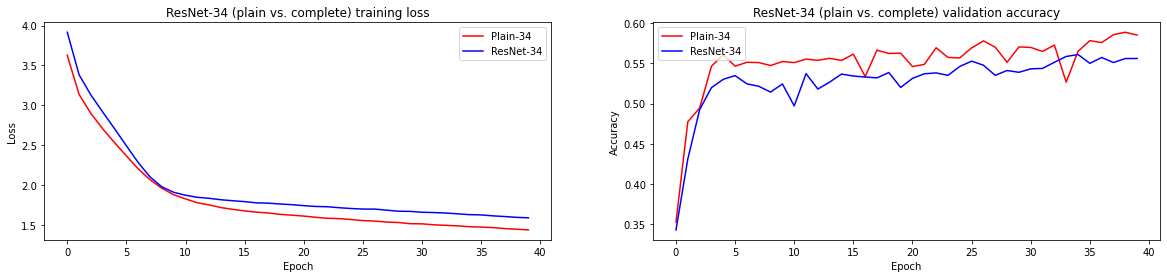

In [39]:
# ResNet-34(plain)와 ResNet-34(shortcut connection) 그래프 비교 
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34_plain.history['loss'], 'r')
plt.plot(history_resnet_34_complete.history['loss'], 'b')
plt.title('ResNet-34 (plain vs. complete) training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34_plain.history['val_accuracy'], 'r')
plt.plot(history_resnet_34_complete.history['val_accuracy'], 'b')
plt.title('ResNet-34 (plain vs. complete) validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34'], loc='upper left')
plt.show()

### ResNet-50(Plain) vs. ResNet-50 using CIFAR-10
- 아래의 그래프와 같이 ResNet50(Plain)과 ResNet50의 training loss는 둘다 비슷하게 감소하는 경향을 보였습니다. 다만 ResNet-34모델 보다는 높은 loss를 나타내고 있습니다. 
- validation accuracy 같은 경우에는 Plain모델과 shortcut connection이 있는 모델 둘다 비슷한 정확도를 보여주었고, ResNet-50 모델이 조금 더 빠르게 높은 정확도를 찾아가는 경향을 확인했습니다. 

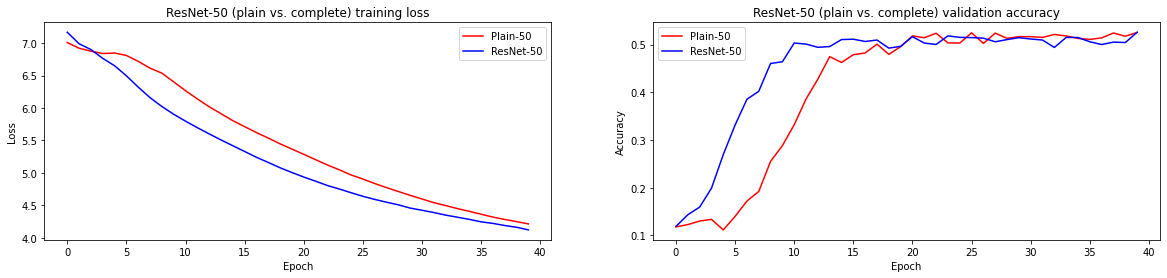

In [40]:
# ResNet-50(plain)와 ResNet-50(shortcut connection) 그래프 비교 
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50_plain.history['loss'], 'r')
plt.plot(history_resnet_50_complete.history['loss'], 'b')
plt.title('ResNet-50 (plain vs. complete) training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain-50', 'ResNet-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50_plain.history['val_accuracy'], 'r')
plt.plot(history_resnet_50_complete.history['val_accuracy'], 'b')
plt.title('ResNet-50 (plain vs. complete) validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-50', 'ResNet-50'], loc='upper left')
plt.show()

### ResNet-34(Plain) vs. ResNet-34 vs. ResNet-50(Plain) vs. ResNet-50 using CIFAR-10
- training loss는 전체적으로 ResNet-34(Plain & complete) 모델이 ResNet-50(Plain & complete) 보다 낮은 loss를 나타내고 있습니다. 
- validation accuracy 같은 경우에도 training loss와 비슷한 경향으로 ResNet-34(Plain & complete) 모델이 ResNet-50(Plain and complete) 조금 더 빠르게 정확도를 찾아가는 경향을 보입니다. ResNet-34 모델들이 조금 더 높을 정확도를 나타내고 있습니다. 

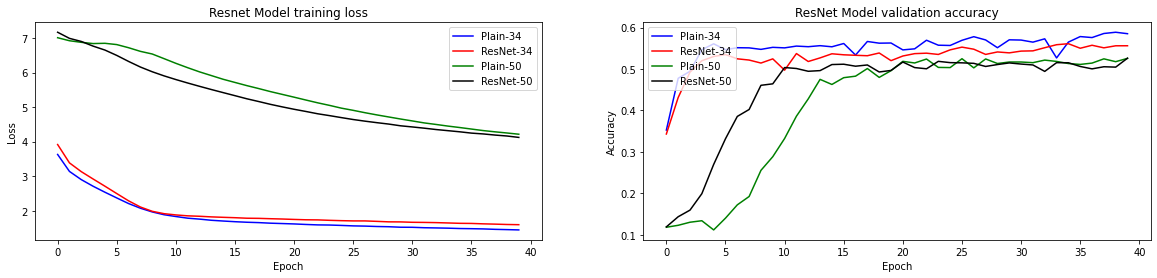

In [38]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34_plain.history['loss'], 'b')
plt.plot(history_resnet_34_complete.history['loss'], 'r')
plt.plot(history_resnet_50_plain.history['loss'], 'g')
plt.plot(history_resnet_50_complete.history['loss'], 'k')
plt.title('Resnet Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34', 'Plain-50', 'ResNet-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34_plain.history['val_accuracy'], 'b')
plt.plot(history_resnet_34_complete.history['val_accuracy'], 'r')
plt.plot(history_resnet_50_plain.history['val_accuracy'], 'g')
plt.plot(history_resnet_50_complete.history['val_accuracy'], 'k')
plt.title('ResNet Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34', 'Plain-50', 'ResNet-50'], loc='upper left')
plt.show()

# **4) CIFAR-100**
-----



In [41]:
#tfds.disable_progress_bar()    # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    shuffle_files = True, 
    with_info = True,    
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteWQ41SX/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteWQ41SX/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [42]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print (ds_info.features)

FeaturesDict({
    'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
})


In [43]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [44]:
ds_info.features["label"].num_classes

100

In [45]:
ds_info.features["label"].names

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

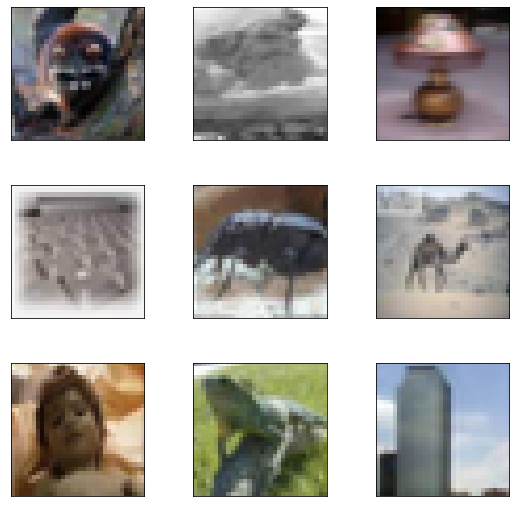

In [46]:
fig = tfds.show_examples(ds_train, ds_info)

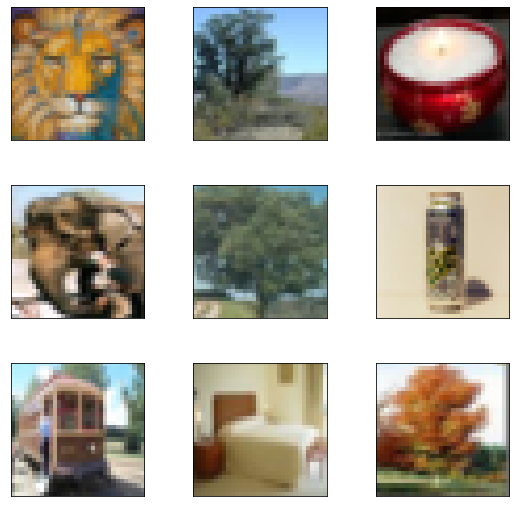

In [47]:
fig = tfds.show_examples(ds_test, ds_info)

In [48]:
BATCH_SIZE = 32
EPOCH = 40

In [49]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [50]:
model_resnet34_plain = build_resnet(input_shape=(32,32,3),
                                    num_classes=100,
                                    resnet34=True,
                                    plain=True,
                                    activation='sigmoid',
                                    name='ResNet_34_plain')

model_resnet50_plain = build_resnet(input_shape=(32,32,3),
                                    num_classes=100,
                                    resnet34=False,
                                    plain=True,
                                    activation='sigmoid',
                                    name='ResNet_50_plain')

model_resnet34_complete = build_resnet(input_shape=(32,32,3),
                                    num_classes=100,
                                    resnet34=True,
                                    plain=False,
                                    activation='sigmoid',
                                    name='ResNet_34_complete')

model_resnet50_complete = build_resnet(input_shape=(32,32,3),
                                    num_classes=100,
                                    resnet34=False,
                                    plain=False,
                                    activation='sigmoid',
                                    name='ResNet_50_complete')

### ResNet-34(Plain) - CIFAR-100

In [51]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/cifar100_resnet34_plain/cifar100_resnet34_plain-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_34_plain = model_resnet34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/cifar100_resnet34_plain/cifar100_resnet34_plain.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
1562/1562 [==============================] - 70s 41ms/step - loss: 5.9625 - accuracy: 0.0555 - val_loss: 5.5352 - val_accuracy: 0.0959
Epoch 2/40
1562/1562 [==============================] - 63s 40ms/step - loss: 5.2697 - accuracy: 0.1279 - val_loss: 5.0508 - val_accuracy: 0.1684
Epoch 3/40
1562/1562 [==============================] - 63s 41ms/step - loss: 4.9423 - accuracy: 0.1831 - val_loss: 4.8854 - val_accuracy: 0.1965
Epoch 4/40
1562/1562 [==============================] - 63s 40ms/step - loss: 4.6729 - accuracy: 0.2283 - val_loss: 4.7720 - val_accuracy: 0.2215
Epoch 5/40
1561/1562 [============================>.] - ETA: 0s - loss: 4.4076 - accuracy: 0.2800
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/cifar100_resnet34_plain/cifar100_resnet34_plain-0005.ckpt
1562/1562 [==============================] - 64s 41ms/step - loss: 4.4078 - accuracy: 0.2799 - val_loss: 4.7192 - val_accuracy: 0.2336
Epoch 6/40
1562/1562 [==================

### ResNet-50(Plain) - CIFAR-100

In [52]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/cifar100_resnet50_plain/cifar100_resnet50_plain-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_50_plain = model_resnet50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/cifar100_resnet50_plain/cifar100_resnet50_plain.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
1562/1562 [==============================] - 79s 44ms/step - loss: 9.3636 - accuracy: 0.0125 - val_loss: 10.5975 - val_accuracy: 0.0132
Epoch 2/40
1562/1562 [==============================] - 68s 44ms/step - loss: 9.2305 - accuracy: 0.0139 - val_loss: 9.7744 - val_accuracy: 0.0123
Epoch 3/40
1562/1562 [==============================] - 68s 44ms/step - loss: 9.1564 - accuracy: 0.0146 - val_loss: 9.3959 - val_accuracy: 0.0163
Epoch 4/40
1562/1562 [==============================] - 68s 44ms/step - loss: 9.1144 - accuracy: 0.0153 - val_loss: 9.2367 - val_accuracy: 0.0183
Epoch 5/40
1561/1562 [============================>.] - ETA: 0s - loss: 9.0756 - accuracy: 0.0171
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/cifar100_resnet50_plain/cifar100_resnet50_plain-0005.ckpt
1562/1562 [==============================] - 69s 44ms/step - loss: 9.0756 - accuracy: 0.0171 - val_loss: 9.4662 - val_accuracy: 0.0181
Epoch 6/40
1562/1562 [=================

### ResNet-34 - CIFAR-100

In [53]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/cifar100_resnet34_complete/cifar100_resnet34_complete-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet34_complete.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_34_complete = model_resnet34_complete.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/cifar100_resnet34_complete/cifar100_resnet34_complete.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
1562/1562 [==============================] - 73s 42ms/step - loss: 6.3973 - accuracy: 0.0487 - val_loss: 5.9544 - val_accuracy: 0.0858
Epoch 2/40
1562/1562 [==============================] - 65s 41ms/step - loss: 5.5108 - accuracy: 0.1235 - val_loss: 5.3241 - val_accuracy: 0.1584
Epoch 3/40
1562/1562 [==============================] - 65s 41ms/step - loss: 5.1443 - accuracy: 0.1859 - val_loss: 5.1464 - val_accuracy: 0.1845
Epoch 4/40
1562/1562 [==============================] - 66s 42ms/step - loss: 4.8129 - accuracy: 0.2431 - val_loss: 5.1246 - val_accuracy: 0.1994
Epoch 5/40
1561/1562 [============================>.] - ETA: 0s - loss: 4.4722 - accuracy: 0.3134
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/cifar100_resnet34_complete/cifar100_resnet34_complete-0005.ckpt
1562/1562 [==============================] - 65s 42ms/step - loss: 4.4721 - accuracy: 0.3134 - val_loss: 5.0497 - val_accuracy: 0.2092
Epoch 6/40
1562/1562 [============

### ResNet-50 - CIFAR-100

In [54]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/cifar100_resnet50_complete/cifar100_resnet50_complete-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet50_complete.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_50_complete = model_resnet50_complete.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/cifar100_resnet50_complete/cifar100_resnet50_complete.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
1562/1562 [==============================] - 151s 91ms/step - loss: 9.6331 - accuracy: 0.0115 - val_loss: 9.9952 - val_accuracy: 0.0151
Epoch 2/40
1562/1562 [==============================] - 145s 93ms/step - loss: 9.3233 - accuracy: 0.0148 - val_loss: 10.0797 - val_accuracy: 0.0166
Epoch 3/40
1562/1562 [==============================] - 141s 90ms/step - loss: 9.1086 - accuracy: 0.0216 - val_loss: 9.1603 - val_accuracy: 0.0254
Epoch 4/40
1562/1562 [==============================] - 141s 90ms/step - loss: 8.8349 - accuracy: 0.0410 - val_loss: 8.8015 - val_accuracy: 0.0477
Epoch 5/40
1562/1562 [==============================] - ETA: 0s - loss: 8.6234 - accuracy: 0.0639
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/cifar100_resnet50_complete/cifar100_resnet50_complete-0005.ckpt
1562/1562 [==============================] - 146s 94ms/step - loss: 8.6234 - accuracy: 0.0639 - val_loss: 8.5206 - val_accuracy: 0.0792
Epoch 6/40
1562/1562 [======

### ResNet-34(Plain) vs. ResNet-34 using CIFAR-100
- 아래의 그래프와 같이 ResNet34(Plain)과 ResNet34의 training loss는 둘다 비슷하게 감소하는 경향을 보였습니다.
- validation accuracy 같은 경우에는 Plain모델이 shortcut connection이 있는 모델보다 조금 더 좋은 정확도를 보여주고 있다가 마지막 epoch40에서 반전되는 결과를 보여주었습니다. 조금 더 오랜시간동안 학습을 진행했다면, 반전되는 결과를 보여주었을 수도 있다고 생각됩니다. 

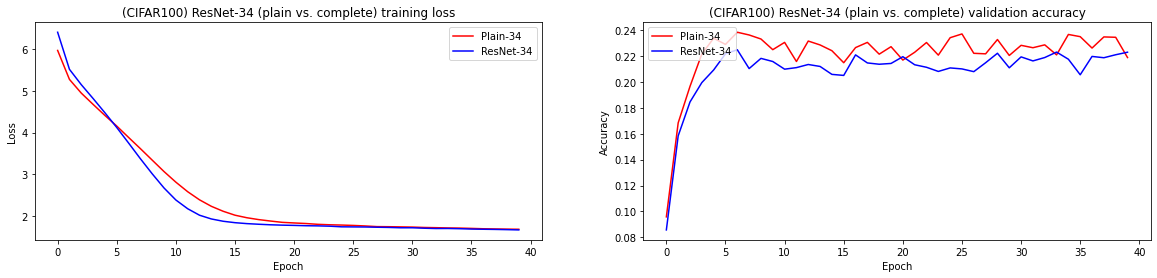

In [55]:
# ResNet-34(plain)와 ResNet-34(shortcut connection) 그래프 비교 
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34_plain.history['loss'], 'r')
plt.plot(history_resnet_34_complete.history['loss'], 'b')
plt.title('(CIFAR100) ResNet-34 (plain vs. complete) training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34_plain.history['val_accuracy'], 'r')
plt.plot(history_resnet_34_complete.history['val_accuracy'], 'b')
plt.title('(CIFAR100) ResNet-34 (plain vs. complete) validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34'], loc='upper left')
plt.show()

### ResNet-50(Plain) vs. ResNet-50 using CIFAR-100
- 아래의 그래프와 같이 ResNet50(Plain)과 ResNet50의 training loss는 둘다 비슷하게 감소하는 경향을 보였습니다. 다만 ResNet-34모델 보다는 높은 loss를 나타내고 있습니다. 
- validation accuracy 같은 경우에는 Plain모델과 shortcut connection이 있는 모델 둘다 비슷한 정확도를 보여주었고, ResNet-50 모델이 조금 더 빠르게 높은 정확도를 찾아가는 경향을 확인했습니다. 

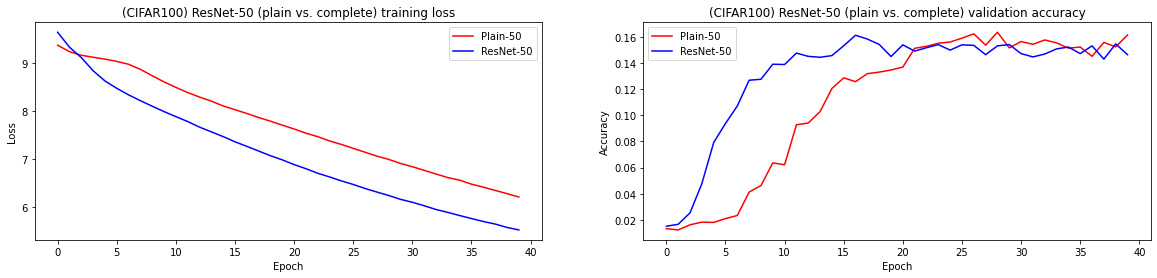

In [56]:
# ResNet-50(plain)와 ResNet-50(shortcut connection) 그래프 비교 
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50_plain.history['loss'], 'r')
plt.plot(history_resnet_50_complete.history['loss'], 'b')
plt.title('(CIFAR100) ResNet-50 (plain vs. complete) training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain-50', 'ResNet-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50_plain.history['val_accuracy'], 'r')
plt.plot(history_resnet_50_complete.history['val_accuracy'], 'b')
plt.title('(CIFAR100) ResNet-50 (plain vs. complete) validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-50', 'ResNet-50'], loc='upper left')
plt.show()

### ResNet-34(Plain) vs. ResNet-34 vs. ResNet-50(Plain) vs. ResNet-50 using CIFAR-100
- training loss는 전체적으로 ResNet-34(Plain & complete) 모델이 ResNet-50(Plain & complete) 보다 낮은 loss를 나타내고 있습니다. 
- validation accuracy 같은 경우에도 training loss와 비슷한 경향으로 ResNet-34(Plain & complete) 모델이 ResNet-50(Plain and complete) 조금 더 빠르게 정확도를 찾아가는 경향을 보입니다. ResNet-34 모델들이 조금 더 높을 정확도를 나타내고 있습니다. 
- classify할 category가 많아질수록 ResNet-34와 ResNet-50 모델의 training loss와 validation accuracy 차이가 커지는 것을 확인할 수 있습니다. 하지만 이번 학습에서는 시간 관계상 epoch 40까지만 진행한 결과임으로 더 오랜 시간동안 학습을 진행한다면 어떤 결과를 보여줄지 궁금합니다. 

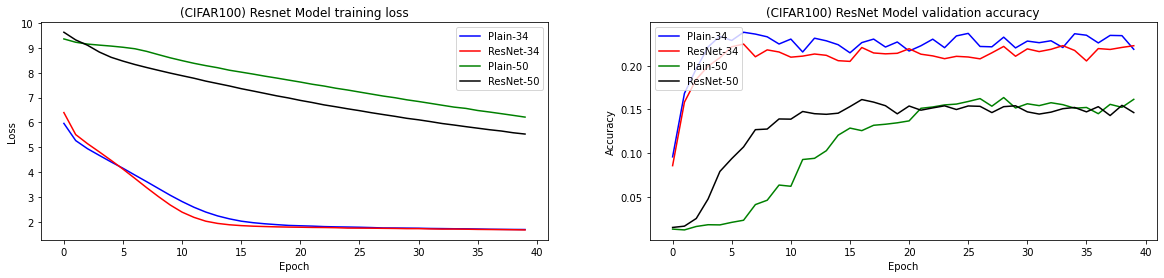

In [57]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34_plain.history['loss'], 'b')
plt.plot(history_resnet_34_complete.history['loss'], 'r')
plt.plot(history_resnet_50_plain.history['loss'], 'g')
plt.plot(history_resnet_50_complete.history['loss'], 'k')
plt.title('(CIFAR100) Resnet Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34', 'Plain-50', 'ResNet-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34_plain.history['val_accuracy'], 'b')
plt.plot(history_resnet_34_complete.history['val_accuracy'], 'r')
plt.plot(history_resnet_50_plain.history['val_accuracy'], 'g')
plt.plot(history_resnet_50_complete.history['val_accuracy'], 'k')
plt.title('(CIFAR100) ResNet Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34', 'Plain-50', 'ResNet-50'], loc='upper left')
plt.show()

# **5) cats vs. dogs**
-----



In [33]:
#tfds.disable_progress_bar()    # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files = True, 
    with_info = True,    
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete1PGPUK/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [34]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print (ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [35]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [36]:
def normalize_and_resize_img(image, label):
  image = tf.image.resize(image, [224, 224])
  return tf.cast(image, tf.float32) / 255., label

In [37]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [38]:
ds_info.features["label"].num_classes

2

In [39]:
ds_info.features["label"].names

['cat', 'dog']

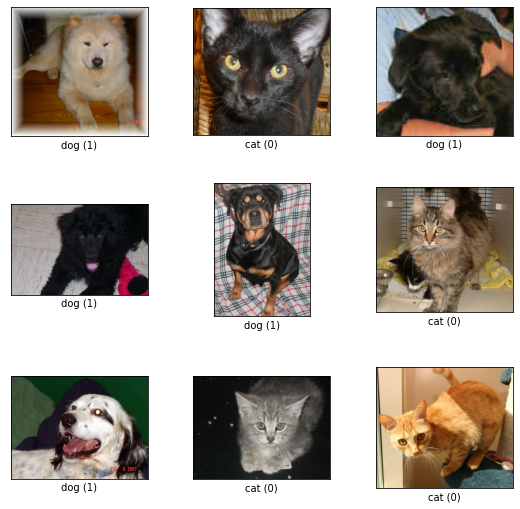

In [40]:
fig = tfds.show_examples(ds_train, ds_info)

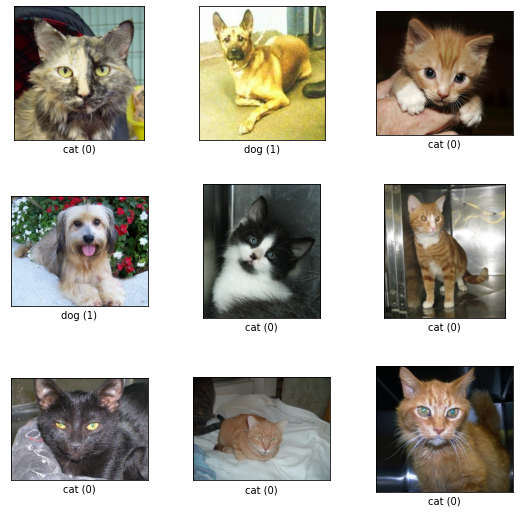

In [41]:
fig = tfds.show_examples(ds_test, ds_info)

In [42]:
BATCH_SIZE = 32
EPOCH = 40

In [43]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files = True, 
    with_info = True,    
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [47]:
model_resnet34_plain = build_resnet(input_shape=(224,224,3),
                                    num_classes=2,
                                    resnet34=True,
                                    plain=True,
                                    activation='sigmoid',
                                    name='ResNet_34_plain')

model_resnet50_plain = build_resnet(input_shape=(224,224,3),
                                    num_classes=2,
                                    resnet34=False,
                                    plain=True,
                                    activation='sigmoid',
                                    name='ResNet_50_plain')

model_resnet34_complete = build_resnet(input_shape=(224,224,3),
                                    num_classes=2,
                                    resnet34=True,
                                    plain=False,
                                    activation='sigmoid',
                                    name='ResNet_34_complete')

model_resnet50_complete = build_resnet(input_shape=(224,224,3),
                                    num_classes=2,
                                    resnet34=False,
                                    plain=False,
                                    activation='sigmoid',
                                    name='ResNet_50_complete')

### ResNet-34(Plain) - cats vs. dogs

In [48]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/catdog_resnet34_plain/catdog_resnet34_plain-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_34_plain = model_resnet34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/catdog_resnet34_plain/catdog_resnet34_plain.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 118s 157ms/step - loss: 2.1696 - accuracy: 0.6239 - val_loss: 2.2251 - val_accuracy: 0.5973
Epoch 2/40
581/581 [==============================] - 87s 150ms/step - loss: 2.1009 - accuracy: 0.6898 - val_loss: 2.2846 - val_accuracy: 0.6678
Epoch 3/40
581/581 [==============================] - 88s 151ms/step - loss: 2.0210 - accuracy: 0.7541 - val_loss: 2.0643 - val_accuracy: 0.7322
Epoch 4/40
581/581 [==============================] - 87s 150ms/step - loss: 1.9580 - accuracy: 0.7918 - val_loss: 2.1669 - val_accuracy: 0.7185
Epoch 5/40
581/581 [==============================] - ETA: 0s - loss: 1.8907 - accuracy: 0.8315
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/catdog_resnet34_plain/catdog_resnet34_plain-0005.ckpt
581/581 [==============================] - 87s 150ms/step - loss: 1.8907 - accuracy: 0.8315 - val_loss: 2.3523 - val_accuracy: 0.6542
Epoch 6/40
581/581 [==============================] - 87s 149

### ResNet-50(Plain) - cats vs. dogs

In [49]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/catdog_resnet50_plain/catdog_resnet50_plain-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_50_plain = model_resnet50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/catdog_resnet50_plain/catdog_resnet50_plain.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 138s 205ms/step - loss: 5.2393 - accuracy: 0.5396 - val_loss: 5.2357 - val_accuracy: 0.5493
Epoch 2/40
581/581 [==============================] - 117s 202ms/step - loss: 5.2330 - accuracy: 0.5366 - val_loss: 5.2289 - val_accuracy: 0.5389
Epoch 3/40
581/581 [==============================] - 118s 202ms/step - loss: 5.2288 - accuracy: 0.5336 - val_loss: 5.2191 - val_accuracy: 0.5539
Epoch 4/40
581/581 [==============================] - 118s 203ms/step - loss: 5.2187 - accuracy: 0.5414 - val_loss: 5.2232 - val_accuracy: 0.5210
Epoch 5/40
581/581 [==============================] - ETA: 0s - loss: 5.2146 - accuracy: 0.5385
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/catdog_resnet50_plain/catdog_resnet50_plain-0005.ckpt
581/581 [==============================] - 118s 204ms/step - loss: 5.2146 - accuracy: 0.5385 - val_loss: 5.3384 - val_accuracy: 0.5203
Epoch 6/40
581/581 [==============================] - 118

### ResNet-34 - cats vs. dogs

In [50]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/catdog_resnet34_complete/catdog_resnet34_complete-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet34_complete.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_34_complete = model_resnet34_complete.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/catdog_resnet34_complete/catdog_resnet34_complete.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 107s 157ms/step - loss: 2.3532 - accuracy: 0.6243 - val_loss: 2.3447 - val_accuracy: 0.6279
Epoch 2/40
581/581 [==============================] - 90s 155ms/step - loss: 2.2915 - accuracy: 0.6775 - val_loss: 2.2735 - val_accuracy: 0.6997
Epoch 3/40
581/581 [==============================] - 92s 158ms/step - loss: 2.2496 - accuracy: 0.7158 - val_loss: 2.2641 - val_accuracy: 0.7067
Epoch 4/40
581/581 [==============================] - 90s 155ms/step - loss: 2.1946 - accuracy: 0.7529 - val_loss: 2.2877 - val_accuracy: 0.7016
Epoch 5/40
581/581 [==============================] - ETA: 0s - loss: 2.1336 - accuracy: 0.7936
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/catdog_resnet34_complete/catdog_resnet34_complete-0005.ckpt
581/581 [==============================] - 91s 157ms/step - loss: 2.1336 - accuracy: 0.7936 - val_loss: 2.3924 - val_accuracy: 0.6801
Epoch 6/40
581/581 [==============================] - 9

### ResNet-50 - cats vs. dogs

In [51]:
checkpoint_path = "/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/catdog_resnet50_complete/catdog_resnet50_complete-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=5)

model_resnet50_complete.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

model.save_weights(checkpoint_path.format(epoch=0))

history_resnet_50_complete = model_resnet50_complete.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

model.save('/content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/model/catdog_resnet50_complete/catdog_resnet50_complete.h5')

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 119s 171ms/step - loss: 5.2575 - accuracy: 0.5326 - val_loss: 5.2557 - val_accuracy: 0.5240
Epoch 2/40
581/581 [==============================] - 98s 169ms/step - loss: 5.2503 - accuracy: 0.5280 - val_loss: 5.2854 - val_accuracy: 0.5447
Epoch 3/40
581/581 [==============================] - 98s 170ms/step - loss: 5.2467 - accuracy: 0.5325 - val_loss: 5.2460 - val_accuracy: 0.5420
Epoch 4/40
581/581 [==============================] - 99s 171ms/step - loss: 5.2341 - accuracy: 0.5529 - val_loss: 5.2915 - val_accuracy: 0.5234
Epoch 5/40
581/581 [==============================] - ETA: 0s - loss: 5.2408 - accuracy: 0.5198
Epoch 5: saving model to /content/drive/MyDrive/AIFFEL/GoingDeeper_CV/resnet/weights/catdog_resnet50_complete/catdog_resnet50_complete-0005.ckpt
581/581 [==============================] - 100s 173ms/step - loss: 5.2408 - accuracy: 0.5198 - val_loss: 5.2769 - val_accuracy: 0.4920
Epoch 6/40
581/581 [==============================] - 

### ResNet-34(Plain) vs. ResNet-34 using cats vs. dogs
- 아래의 그래프와 같이 ResNet34(Plain)과 ResNet34의 training loss는 둘다 비슷하게 감소하는 경향을 보였지만, plain모델이 조금 더 낮은 loss를 보여주었습니다.
- validation accuracy 같은 경우에는 Plain모델이 shortcut connection이 있는 모델보다 조금 더 좋은 정확도를 보여주었습니다. 

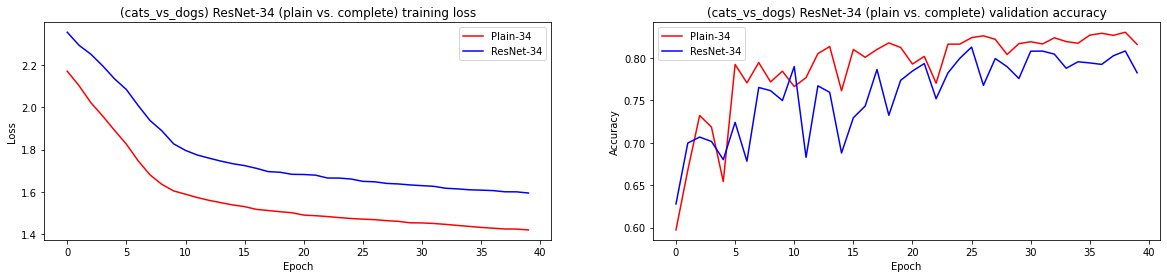

In [52]:
# ResNet-34(plain)와 ResNet-34(shortcut connection) 그래프 비교 
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34_plain.history['loss'], 'r')
plt.plot(history_resnet_34_complete.history['loss'], 'b')
plt.title('(cats_vs_dogs) ResNet-34 (plain vs. complete) training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34_plain.history['val_accuracy'], 'r')
plt.plot(history_resnet_34_complete.history['val_accuracy'], 'b')
plt.title('(cats_vs_dogs) ResNet-34 (plain vs. complete) validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34'], loc='upper left')
plt.show()

### ResNet-50(Plain) vs. ResNet-50 using cats vs. dogs
- ResNet-34(plain) vs. ResNet-34 그래프와는 다르게 ResNet-50의 training loss의 값이 plain 모델보다는 가파르게 떨어지는 것을 확인할 수 있었습니다. 다만 ResNet-34모델 보다는 높은 loss를 나타내고 있습니다. 
- validation accuracy 같은 경우에는 shortcut connection이 있는 모델이 Plain모델보다는 더 높은 정확도를 보여 주었습니다.

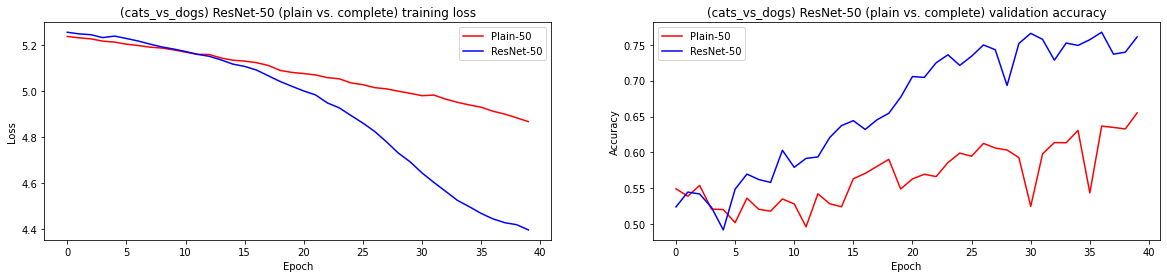

In [53]:
# ResNet-50(plain)와 ResNet-50(shortcut connection) 그래프 비교 
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50_plain.history['loss'], 'r')
plt.plot(history_resnet_50_complete.history['loss'], 'b')
plt.title('(cats_vs_dogs) ResNet-50 (plain vs. complete) training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain-50', 'ResNet-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50_plain.history['val_accuracy'], 'r')
plt.plot(history_resnet_50_complete.history['val_accuracy'], 'b')
plt.title('(cats_vs_dogs) ResNet-50 (plain vs. complete) validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-50', 'ResNet-50'], loc='upper left')
plt.show()

### ResNet-34(Plain) vs. ResNet-34 vs. ResNet-50(Plain) vs. ResNet-50 using cats vs. dogs
- training loss는 전체적으로 ResNet-34(Plain & complete) 모델이 ResNet-50(Plain & complete) 보다 낮은 loss를 나타내고 있습니다. 
- validation accuracy 같은 경우에도 training loss와 비슷한 경향으로 ResNet-34(Plain & complete) 모델이 ResNet-50(Plain and complete) 조금 더 빠르게 정확도를 찾아가는 경향을 보입니다. ResNet-34 모델들이 조금 더 높을 정확도를 나타내고 있습니다. 
- 하지만 이번 학습에서는 시간 관계상 epoch 40까지만 진행한 결과임으로 더 오랜 시간동안 학습을 진행한다면 shortcut connection이 있는 ResNet-50 모델의 validation accuracy가 더 상승하지 않았을까 생각됩니다.

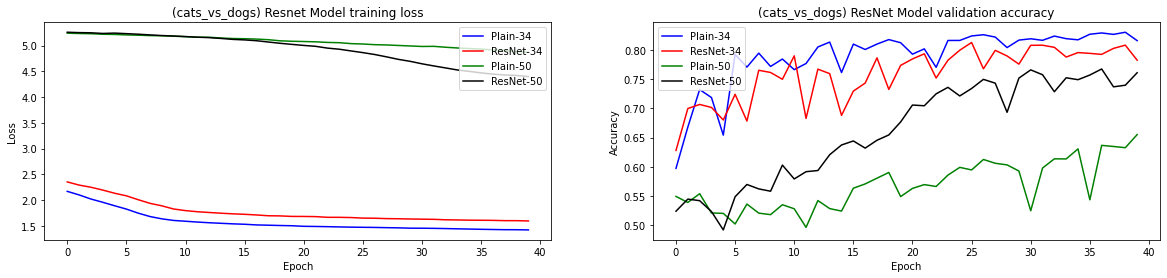

In [54]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34_plain.history['loss'], 'b')
plt.plot(history_resnet_34_complete.history['loss'], 'r')
plt.plot(history_resnet_50_plain.history['loss'], 'g')
plt.plot(history_resnet_50_complete.history['loss'], 'k')
plt.title('(cats_vs_dogs) Resnet Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34', 'Plain-50', 'ResNet-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34_plain.history['val_accuracy'], 'b')
plt.plot(history_resnet_34_complete.history['val_accuracy'], 'r')
plt.plot(history_resnet_50_plain.history['val_accuracy'], 'g')
plt.plot(history_resnet_50_complete.history['val_accuracy'], 'k')
plt.title('(cats_vs_dogs) ResNet Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34', 'Plain-50', 'ResNet-50'], loc='upper left')
plt.show()